# README

TODO

# Libraries

In [22]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [23]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'InversionExp_Characteristics'
data_file = 'TDA_freq_DATA'
exp_date = '01Apr24'
run_head = 'trueStart'

SNR_value = 1000
var_reps = 100000

add_tag = ""

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [24]:
with open(f'{cwd_full}{base_file}/{exp_file}/{data_file}/hprParameter_{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    check_SNR_value = dict['SNR_value']
    TI_DATA = dict['TI_DATA']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    check_var_reps = dict["var_reps"]
    rand_start = dict["rand_start"]
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

assert(SNR_value == check_SNR_value)
assert(check_var_reps == var_reps)

details = f"\nSNR {SNR_value} :: iterations {var_reps}\n{ParamTitle_6p} = [{T11} {T12} {c1} {c2}, {T21}, {T22}]"

# Functions

In [25]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI"].values) #shape: 
    ALL_TD_params = np.stack(df["params1"].values) #shape: 
    ALL_OD_params = np.stack(df["params2"].values) #shape: 
    ALL_TD_RSS = np.stack(df["RSS1"].values) #shape: 
    ALL_OD_RSS = np.stack(df["RSS2"].values) #shape:
    ALL_NR = np.stack(df["NR"].values) #shape:

    return ALL_TI, ALL_TD_params, ALL_OD_params, ALL_TD_RSS, ALL_OD_RSS, ALL_NR

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [26]:
def prepare_data():
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    params1_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    params2_ordered = np.zeros((len(TI_DATA), var_reps//2, 4))
    RSS1_ordered = np.zeros((len(TI_DATA), var_reps//2))
    RSS2_ordered = np.zeros((len(TI_DATA), var_reps//2))
    
    data_name = f"{cwd_full}{base_file}/{exp_file}/{data_file}/{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI, param1, param2, RSS1, RSS2, NR = to_readable_2DWindow(data_name)

    for index in range(len(TI)):

        temp_TI = TI[index]

        TI_index = np.where(temp_TI==TI_DATA)[0][0]

        nr_index = NR[index]

        params1_ordered[TI_index,nr_index,:] = param1[index,:]
        params2_ordered[TI_index,nr_index,:] = param2[index,:]
        RSS1_ordered[TI_index,nr_index] = RSS1[index]
        RSS2_ordered[TI_index,nr_index] = RSS2[index]

    # params = np.append(params1_ordered, params2_ordered)
    # RSS = np.append(RSS1_ordered, RSS2_ordered)

    return np.append(params1_ordered, params2_ordered, axis=1), np.append(RSS1_ordered, RSS2_ordered, axis=1)

# Data Organization

In [27]:
param_estimates, RSS = prepare_data()


Retrieving data for /home/hamptong2/Stabilization/InversionExp_Characteristics/TDA_freq_DATA/trueStart_SNR1000_iter100000_01Apr24.pkl


In [28]:
print(param_estimates.shape)

(8, 100000, 4)


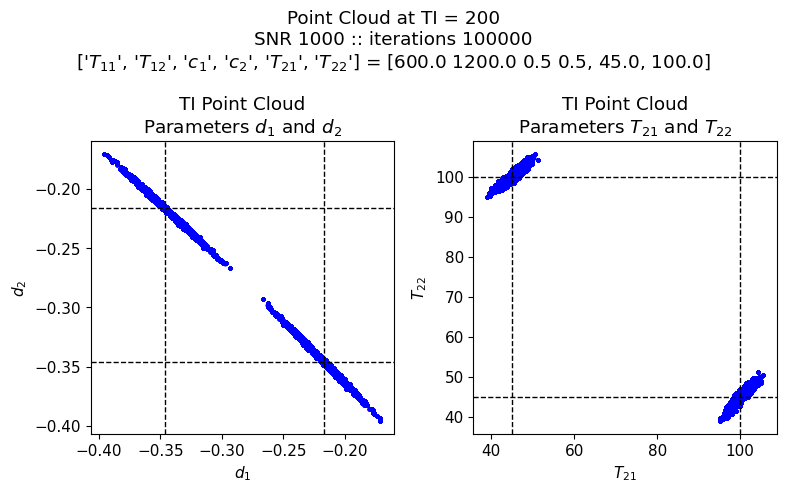

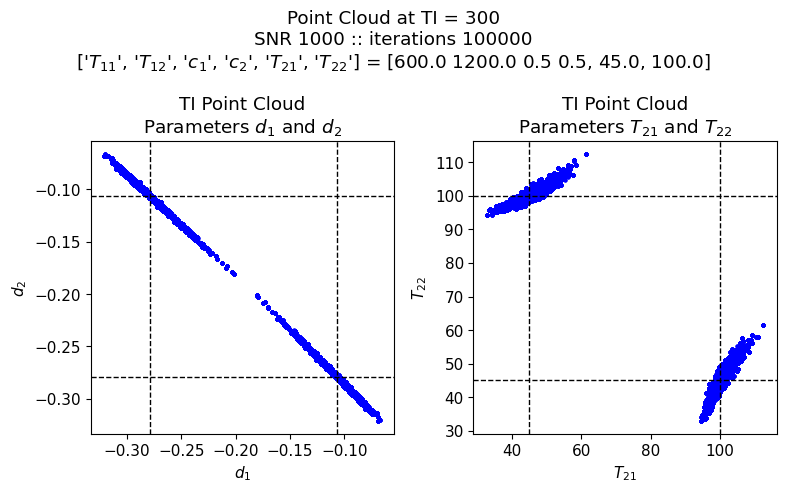

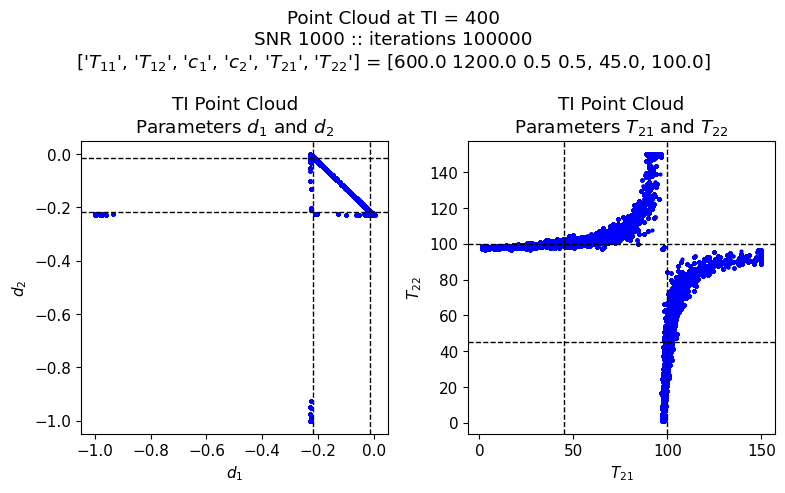

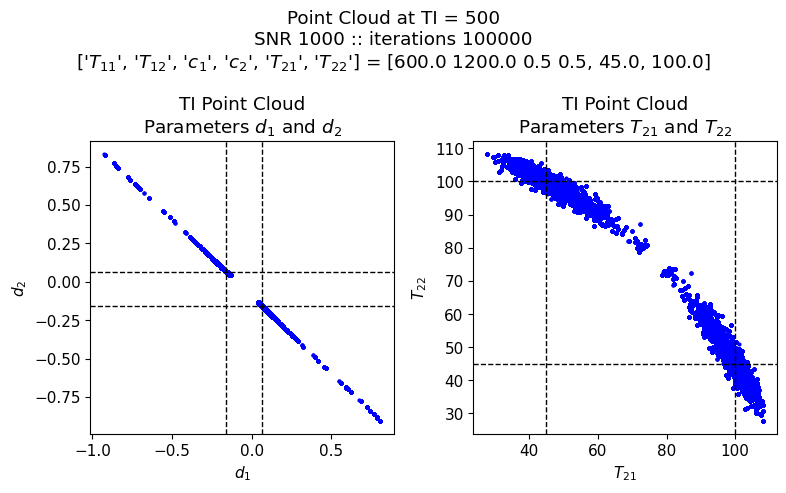

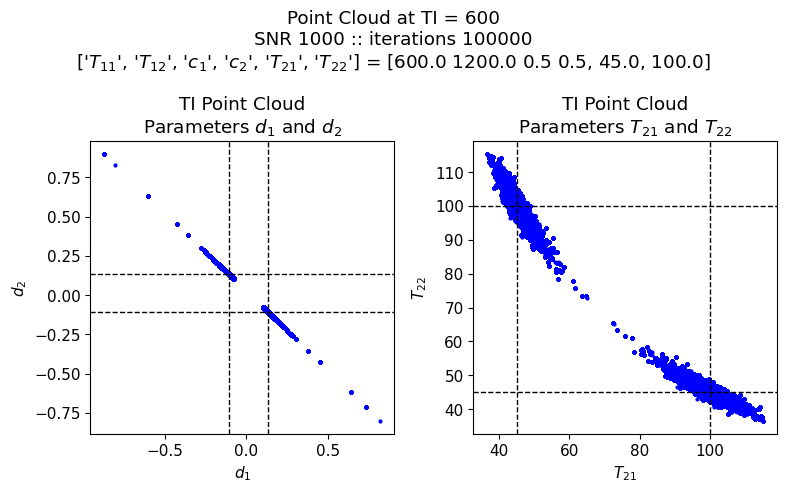

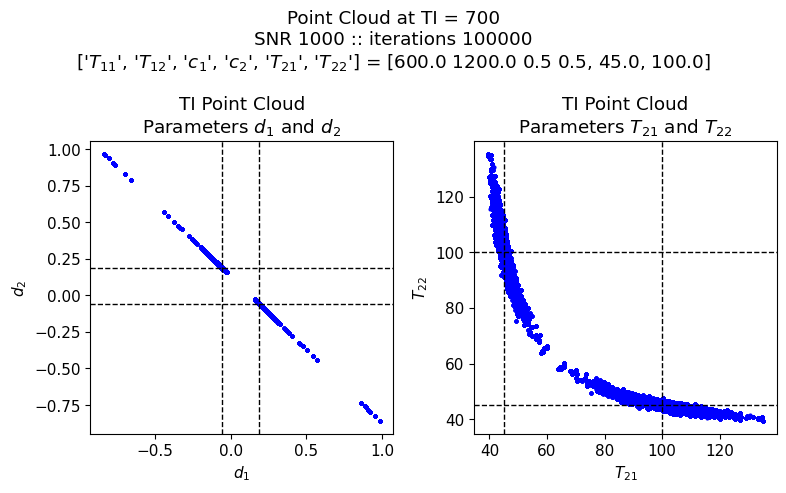

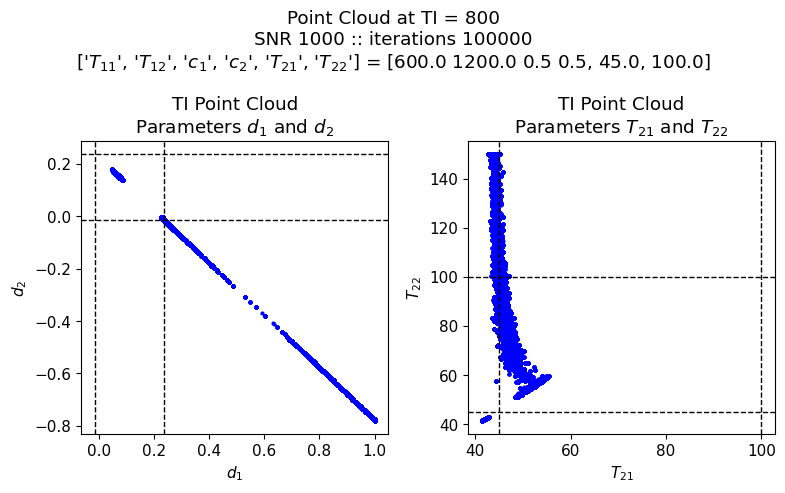

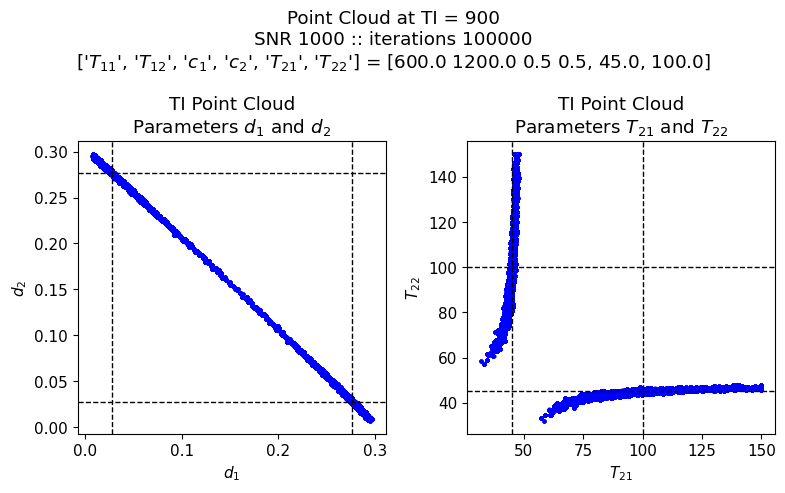

In [32]:
for iTI in range(len(TI_DATA)):
    TI_oi = TI_DATA[iTI]

    temp_true_params = [d_value(TI_oi, c1, T11), d_value(TI_oi, c2, T12), T21, T22]

    fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
    plt.rc('font', size = 11)
    fig.suptitle(f'Point Cloud at TI = {TI_oi}' + details)
    for i in range(2):
        ax[i].plot(param_estimates[iTI,:,2*i], param_estimates[iTI,:,2*i+1], ls = '', color='b', marker = 'o', markersize = 2)
        ax[i].axvline(x = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axvline(x = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i], linewidth=1, color='k', ls = '--')
        ax[i].axhline(y = temp_true_params[2*i+1], linewidth=1, color='k', ls = '--')
        ax[i].set_xlabel(ParamTitle_4p[2*i])
        ax[i].set_ylabel(ParamTitle_4p[2*i+1])
        ax[i].set_title(f'TI Point Cloud\nParameters {ParamTitle_4p[2*i]} and {ParamTitle_4p[2*i+1]}')
        # ax[i].legend()
    plt.show()

/tmp/ipykernel_154661/3924931161.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_154661/3924931161.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,1], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')


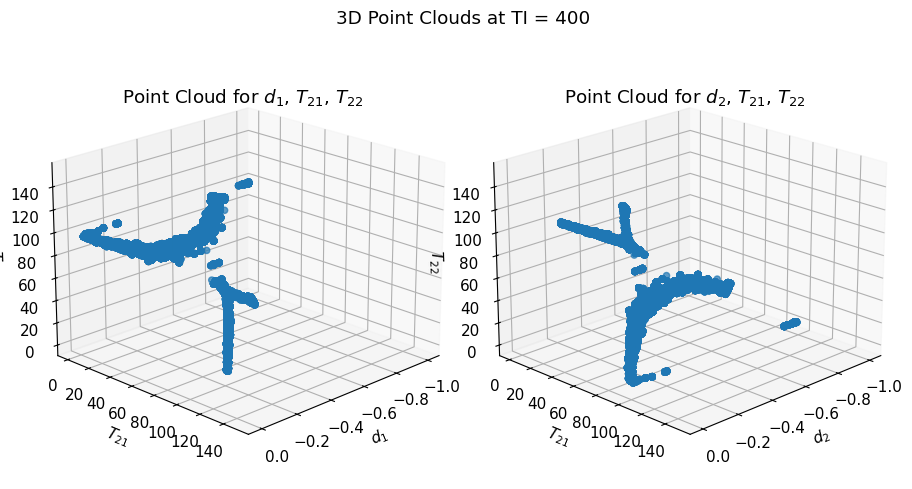

In [30]:
fig = plt.figure(figsize=(9,5), tight_layout=True)

iTI = 2
TI_oi = TI_DATA[iTI]

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[2])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[2]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

ax1.scatter(param_estimates[iTI,:,1], param_estimates[iTI,:,2], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[1])
ax1.set_ylabel(ParamTitle_4p[2])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[1]}, {ParamTitle_4p[2]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

fig.suptitle(f"3D Point Clouds at TI = {TI_oi}")

plt.show()

/tmp/ipykernel_154661/4033098276.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,2], alpha = 0.7, cmap = 'turbo')
/tmp/ipykernel_154661/4033098276.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')


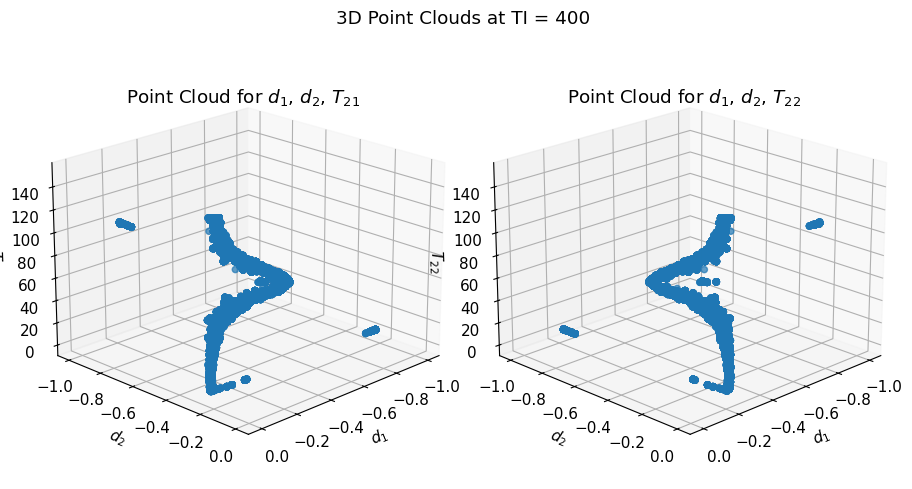

In [31]:
fig = plt.figure(figsize=(9,5), tight_layout=True)

iTI = 2
TI_oi = TI_DATA[iTI]

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,2], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[1])
ax1.set_zlabel(ParamTitle_4p[2])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[1]}, {ParamTitle_4p[2]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

ax1.scatter(param_estimates[iTI,:,0], param_estimates[iTI,:,1], param_estimates[iTI,:,3], alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(ParamTitle_4p[0])
ax1.set_ylabel(ParamTitle_4p[1])
ax1.set_zlabel(ParamTitle_4p[3])
ax1.set_title(f'Point Cloud for {ParamTitle_4p[0]}, {ParamTitle_4p[1]}, {ParamTitle_4p[3]}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

fig.suptitle(f"3D Point Clouds at TI = {TI_oi}")

plt.show()